In [2]:
import math
import torch
import torch.nn as nn
from kernels import RBF
from copy import deepcopy


/disk/scratch1/adamjelley/miniconda3/envs/CORL/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
K = RBF()


In [4]:
X = torch.randn(4, 5)
Y = torch.randn(8, 5)


In [5]:
K(X, Y).shape


torch.Size([4, 8])

In [6]:
X


tensor([[-1.4335,  0.5734,  0.0320, -1.6215, -1.4939],
        [-0.1914, -0.1111,  0.8338,  0.2083, -0.3777],
        [-0.2607, -1.0506,  0.0431, -0.1642,  0.5468],
        [-0.0816, -0.8182,  0.3603,  0.6003, -0.8229]])

In [7]:
K(X, X)


tensor([[1.0000, 0.0108, 0.0016, 0.0031],
        [0.0108, 1.0000, 0.2090, 0.5068],
        [0.0016, 0.2090, 1.0000, 0.1914],
        [0.0031, 0.5068, 0.1914, 1.0000]])

In [8]:
Y


tensor([[ 1.4444,  1.2142,  2.0666,  0.2998, -0.2833],
        [-0.9098, -0.8398, -0.5643, -1.2406,  0.7542],
        [ 0.2916,  0.9453,  0.0495,  0.4850,  0.7981],
        [-1.7931, -0.5190,  0.2280,  0.3369, -1.2903],
        [-0.0423,  2.1562,  0.0412,  0.6128, -0.2299],
        [ 0.0770, -0.0808, -0.2820,  0.0927, -0.1821],
        [-0.7883,  0.3864,  1.6741,  0.2237, -0.6312],
        [-0.5955, -0.4297,  0.8611, -1.2079, -0.0347]])

In [9]:
class VectorizedLinear(nn.Module):
    def __init__(self, in_features: int, out_features: int, ensemble_size: int):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.ensemble_size = ensemble_size

        self.weight = nn.Parameter(torch.empty(ensemble_size, in_features, out_features))
        self.bias = nn.Parameter(torch.empty(ensemble_size, 1, out_features))

        self.reset_parameters()

    def reset_parameters(self):
        # default pytorch init for nn.Linear module
        for layer in range(self.ensemble_size):
            nn.init.kaiming_uniform_(self.weight[layer], a=math.sqrt(5))

        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight[0])
        bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
        nn.init.uniform_(self.bias, -bound, bound)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # input: [ensemble_size, batch_size, input_size]
        # weight: [ensemble_size, input_size, out_size]
        # out: [ensemble_size, batch_size, out_size]
        return x @ self.weight + self.bias


In [10]:
class VectorizedCritic(nn.Module):
    def __init__(
        self, state_dim: int, action_dim: int, hidden_dim: int, num_critics: int
    ):
        super().__init__()
        self.critic = nn.Sequential(
            VectorizedLinear(state_dim + action_dim, hidden_dim, num_critics),
            nn.ReLU(),
            VectorizedLinear(hidden_dim, hidden_dim, num_critics),
            nn.ReLU(),
            VectorizedLinear(hidden_dim, hidden_dim, num_critics),
            nn.ReLU(),
            VectorizedLinear(hidden_dim, 1, num_critics),
        )
        # init as in the EDAC paper
        for layer in self.critic[::2]:
            torch.nn.init.constant_(layer.bias, 0.1)

        torch.nn.init.uniform_(self.critic[-1].weight, -3e-3, 3e-3)
        torch.nn.init.uniform_(self.critic[-1].bias, -3e-3, 3e-3)

        self.num_critics = num_critics

    def forward(self, state: torch.Tensor, action: torch.Tensor) -> torch.Tensor:
        # [..., batch_size, state_dim + action_dim]
        state_action = torch.cat([state, action], dim=-1)
        if state_action.dim() != 3:
            assert state_action.dim() == 2
            # [num_critics, batch_size, state_dim + action_dim]
            state_action = state_action.unsqueeze(0).repeat_interleave(
                self.num_critics, dim=0
            )
        assert state_action.dim() == 3
        assert state_action.shape[0] == self.num_critics
        # [num_critics, batch_size]
        q_values = self.critic(state_action).squeeze(-1)
        return q_values


In [11]:
critic = VectorizedCritic(17, 6, 256, 10)


In [12]:
for parameters in critic.parameters():
    parameters = parameters.reshape(10, -1)
    kernel_values = K(parameters, parameters.detach())
    print(kernel_values.shape)


torch.Size([10, 10])
torch.Size([10, 10])
torch.Size([10, 10])
torch.Size([10, 10])
torch.Size([10, 10])
torch.Size([10, 10])
torch.Size([10, 10])
torch.Size([10, 10])


In [13]:
all_parameters = torch.cat(
    [parameters.reshape(10, -1) for parameters in critic.parameters()], dim=1
)
kernel_values = K(all_parameters, all_parameters.detach())


In [14]:
kernel_grads = torch.autograd.grad(kernel_values.sum(), all_parameters)[0]


In [15]:
kernel_grads[0].mean(0).shape
# kernel_grads.shape


torch.Size([])

In [16]:
kernel_grads[0].shape
all_parameters.shape


torch.Size([10, 137985])

In [17]:
actions = torch.stack(
    [torch.stack([torch.randn(6) for i in range(10)], dim=0) for i in range(3)], dim=0
)
states = torch.stack([torch.randn(17).repeat(10, 1) for i in range(3)], dim=0)
print(actions.shape)
print(states.shape)
currentQ = torch.cat([states, actions], dim=1).mean(0, keepdim=True)
indices = currentQ.max(1).indices
states[0, 15]
states[0, indices]
# indices=currentQ.max(dim=1).indices


torch.Size([3, 10, 6])
torch.Size([3, 10, 17])


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 17 but got size 6 for tensor number 1 in the list.

In [18]:
optimizer = torch.optim.Adam(critic.parameters(), lr=0.1)


In [147]:
type(optimizer.param_groups[0]["params"])
param_grads = [param.grad for param in optimizer.param_groups[0]["params"]]
print(param_grads[0])
optimizer.zero_grad()
for param in optimizer.param_groups[0]["params"]:
    param.grad = torch.ones_like(param)


tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0., 

In [151]:
optimizer.param_groups[0]["params"].grad


AttributeError: 'list' object has no attribute 'grad'

In [99]:
all_grad = torch.cat(
    [param.grad.view(10, -1) for param in optimizer.param_groups[0]["params"]], dim=1
)
all_grad.shape


torch.Size([10, 137985])

In [103]:
optimizer.zero_grad()
torch.cat([param.grad.reshape(10,-1) for param in optimizer.param_groups[0]['params']], dim=1) = all_grad

SyntaxError: cannot assign to function call here. Maybe you meant '==' instead of '='? (448636623.py, line 2)

In [56]:
all_parameters = torch.cat(
    [parameters.reshape(10, -1) for parameters in optimizer.param_groups[0]["params"]],
    dim=1,
).retain_grad()


In [137]:
actions = torch.stack([torch.randn(6) for i in range(10)], dim=0)
states = torch.randn(17).repeat(10, 1)
q_target = torch.randn(10, 1)
q_values = critic(states, actions)
print(q_values.shape)
# [ensemble_size, batch_size] - [1, batch_size]
critic_loss = ((q_values - q_target.view(1, -1)) ** 2).mean(dim=1).sum(dim=0)
[param.retain_grad() for param in optimizer.param_groups[0]["params"]]
critic_loss.backward()


torch.Size([10, 10])


In [ ]:
actions = torch.stack([torch.randn(6) for i in range(10)], dim=0)
states = torch.randn(17).repeat(10, 1)
q_values = critic(states, actions)


In [ ]:
class SVGD:
    def __init__(self, kernel, optimizer):
        self.K = kernel
        self.optim = optimizer
        self.params = torch.cat(
            [
                parameters.reshape(10, -1)
                for parameters in self.optim.param_groups[0]["params"]
            ],
            dim=1,
        )

    def phi(self, loss):
        params = self.params.detach().requires_grad_(True)
        print(params.shape)
        print(loss.shape)

        score_function = torch.autograd.grad(loss, params)[0]

        K_params = self.K(params, params.detach())
        grad_K = -torch.autograd.grad(K_params.sum(), params)[0]

        phi = (K_params.detach().matmul(score_function) + grad_K) / params.size(0)

        return phi

    def step(self, loss):
        self.optim.zero_grad()
        self.params.grad = -self.phi(loss)
        self.optim.step()


In [44]:
[param.retain_grad() for param in critic.parameters()]


[None, None, None, None, None, None, None, None]

In [65]:
param = [param for param in critic.parameters()][0]
param.grad.view(1, -1)


tensor([[-0.0002,  0.0002,  0.0002,  ..., -0.0003, -0.0002,  0.0001]])

In [49]:
params = torch.cat(
    [parameters.reshape(10, -1) for parameters in optimizer.param_groups[0]["params"]],
    dim=1,
).retain_grad()
print(params.shape)


NameError: name 'optimizer' is not defined

In [114]:
# params = torch.cat([parameters.reshape(10,-1) for parameters in critic.parameters()], dim=1)
# params = params.detach().requires_grad_(True)
actions = torch.stack([torch.randn(6) for i in range(10)], dim=0)
states = torch.randn(17).repeat(10, 1)
q_target = torch.randn(10, 1).detach()
q_values = critic(states, actions)

# [ensemble_size, batch_size] - [1, batch_size]
critic_loss = ((q_values - q_target.view(1, -1)) ** 2).mean(dim=1).sum(dim=0)

critic_loss.backward()


In [112]:
print(critic.parameters().__next__().grad.shape)


torch.Size([10, 23, 256])


In [182]:
optimizer.param_groups[0]["params"][0].shape


torch.Size([10, 23, 256])

In [ ]:
K_params = self.K(params, params.detach())
grad_K = -torch.autograd.grad(K_params.sum(), params)[0]

phi = (K_params.detach().matmul(score_function) + grad_K) / params.size(0)


In [ ]:
class SVGD:
    def __init__(self, kernel, optimizer):
        self.K = kernel
        self.optim = optimizer
        self.params = torch.cat(
            [
                parameters.view(10, -1)
                for parameters in self.optim.param_groups[0]["params"]
            ],
            dim=1,
        )

    def backward(self, loss_function, **args):
        loss = loss_function(**args)
        self.optim.zero_grad()
        loss.backward()

        score_function = torch.cat(
            [
                parameters.grad.reshape(10, -1)
                for parameters in self.optim.param_groups[0]["params"]
            ],
            dim=1,
        )

        self.optim.zero_grad()
        params = self.params.detach().requires_grad_(True)

        K_params = self.K(params, params.detach())
        grad_K = -torch.autograd.grad(K_params.sum(), params)[0]

        phi = (K_params.detach().matmul(score_function) + grad_K) / params.size(0)

        phi = score_function

        self.phi = phi

        return loss

    def step(self):
        self.optim.zero_grad()
        self.params.grad = -self.phi
        self.optim.step()


In [152]:
optimizer = torch.optim.Adam(critic.parameters(), lr=0.1)


In [178]:
actions = torch.stack([torch.randn(6) for i in range(10)], dim=0)
states = torch.randn(17).repeat(10, 1)
q_target = torch.randn(10, 1).detach()
q_values = critic(states, actions)

# [ensemble_size, batch_size] - [1, batch_size]
critic_loss = ((q_values - q_target.view(1, -1)) ** 2).mean(dim=1).sum(dim=0)

optimizer.zero_grad()
print(optimizer.param_groups[0]["params"][0].grad.mean())

critic_loss.backward()
print(optimizer.param_groups[0]["params"][0].grad.mean())
score_function = [deepcopy(param.grad) for param in optimizer.param_groups[0]["params"]]
print(score_function[0].mean())
optimizer.zero_grad()
print(score_function[0].mean())
print(optimizer.param_groups[0]["params"][0].grad.mean())
for param, phi in zip(optimizer.param_groups[0]["params"], score_function):
    param.grad = phi
print(optimizer.param_groups[0]["params"][0].grad.mean())


tensor(0.)
tensor(6.7218e-07)
tensor(6.7218e-07)
tensor(6.7218e-07)
tensor(0.)
tensor(6.7218e-07)


In [173]:
optimizer.param_groups[0]["params"][0].view(10, -1).matmul(
    optimizer.param_groups[0]["params"][0].view(10, -1).T
).shape


torch.Size([10, 10])

In [211]:
all_params = (
    torch.cat(
        [param.view(10, -1) for param in optimizer.param_groups[0]["params"]], dim=1
    )
    .detach()
    .requires_grad_(True)
)
score = [deepcopy(param.grad) for param in optimizer.param_groups[0]["params"]]


K_params = K(all_params, all_params.detach())
grad_K = -torch.autograd.grad(K_params.sum(), all_params)[0]

for layer, params in enumerate(optimizer.param_groups[0]["params"]):
    shape = params.shape

    print(K_params.shape)
    print(score[layer].view(10, -1).shape)
    print(grad_K.shape)
    phi = (K_params.detach().matmul(score[layer].view(10, -1)) + grad_K) / params.size(0)


torch.Size([10, 10])
torch.Size([10, 5888])
torch.Size([10, 137985])


RuntimeError: The size of tensor a (5888) must match the size of tensor b (137985) at non-singleton dimension 1

In [187]:
score[0].shape


torch.Size([10, 23, 256])

In [194]:
a = torch.tensor([1, 2, 3, 4])
torch.median(a)


tensor(2)

In [ ]:
class SVGD:
    def __init__(self, kernel, optimizer):
        self.K = kernel
        self.optim = optimizer
        self.params = [param for param in self.optim.param_groups[0]["params"]]

    def backward(self, loss_function, **args):
        loss = loss_function(**args)
        self.optim.zero_grad()
        loss.backward()

        score = [deepcopy(param.grad) for param in self.params]
        phi_all = []

        self.optim.zero_grad()
        for layer, params in enumerate(self.params):
            shape = params.shape
            params = params.view(10, -1).detach().requires_grad_(True)

            K_params = self.K(params, params.detach())
            grad_K = -torch.autograd.grad(K_params.sum(), params)[0]

            phi = (
                K_params.detach().matmul(score[layer].reshape(10, -1)) + grad_K
            ) / params.size(0)

            phi_all.append(phi.reshape(shape))
        # params = [param.view(10,-1).detach().requires_grad_(True) for param in self.params]

        # K_params = self.K(params, params.detach())
        # grad_K = -torch.autograd.grad(K_params.sum(), params)[0]

        # phi = (K_params.detach().matmul(score_function) + grad_K) / params.size(0)

        self.phi = phi_all

        return loss


In [233]:
optimizer.zero_grad()
print([param.grad for param in optimizer.param_groups[0]["params"]][0].mean())
params = torch.cat(
    [param.view(10, -1) for param in optimizer.param_groups[0]["params"]], dim=1
)
params.retain_grad()
K_params = K(params, params.detach())
K_params.sum().backward()
print(params.grad.shape)
print([param.grad for param in optimizer.param_groups[0]["params"]][0].mean())
grads = [param.grad for param in optimizer.param_groups[0]["params"]]


tensor(0.)
torch.Size([10, 137985])
tensor(1.2654e-13)


In [46]:
optimizer.zero_grad()
print([param.grad for param in optimizer.param_groups[0]["params"]][0].mean())
params = torch.cat(
    [param.view(10, -1) for param in optimizer.param_groups[0]["params"]], dim=1
)
params.retain_grad()

actions = torch.stack([torch.randn(6) for i in range(10)], dim=0)
states = torch.randn(17).repeat(10, 1)
q_target = torch.randn(10, 1)
q_values = critic(states, actions)

# [ensemble_size, batch_size] - [1, batch_size]
critic_loss = ((q_values - q_target.view(1, -1)) ** 2).mean(dim=1).sum(dim=0)
critic_loss.backward()
print([param.grad for param in optimizer.param_groups[0]["params"]][0].mean())
print(params.grad)


tensor(0.)
tensor(-9.4986e-07)
None


In [250]:
print(params.grad)


None


In [252]:
print([param.grad for param in optimizer.param_groups[0]["params"]][0].shape)


torch.Size([10, 23, 256])


In [23]:
shapes = [param.shape for param in optimizer.param_groups[0]["params"]]
shapes


[torch.Size([10, 23, 256]),
 torch.Size([10, 1, 256]),
 torch.Size([10, 256, 256]),
 torch.Size([10, 1, 256]),
 torch.Size([10, 256, 256]),
 torch.Size([10, 1, 256]),
 torch.Size([10, 256, 1]),
 torch.Size([10, 1, 1])]

In [29]:
lengths = tuple(
    [int(param.numel() / 10) for param in optimizer.param_groups[0]["params"]]
)
lengths


(5888, 256, 65536, 256, 65536, 256, 256, 1)

In [79]:
optimizer.zero_grad()
print(optimizer.param_groups[0]["params"][0].grad.mean())

actions = torch.stack([torch.randn(6) for i in range(10)], dim=0)
states = torch.randn(17).repeat(10, 1)
q_target = torch.randn(10, 1).detach()
q_values = critic(states, actions)

# [ensemble_size, batch_size] - [1, batch_size]
critic_loss = ((q_values - q_target.view(1, -1)) ** 2).mean(dim=1).sum(dim=0)

critic_loss.backward()

score = torch.cat(
    [
        param.grad.view(param.size(0), -1)
        for param in optimizer.param_groups[0]["params"]
    ],
    dim=1,
)
print(score.mean())
optimizer.zero_grad()

params = (
    torch.cat(
        [param.view(param.size(0), -1) for param in optimizer.param_groups[0]["params"]],
        dim=1,
    )
    .detach()
    .requires_grad_()
)
K_params = K(params, params.detach())
grad_K = -torch.autograd.grad(K_params.sum(), params)[0]
phi = (K_params.detach().matmul(score) + grad_K) / params.size(0)
print(phi.mean())

lengths = tuple(
    [int(param.numel() / param.size(0)) for param in optimizer.param_groups[0]["params"]]
)

for param, phi in zip(
    optimizer.param_groups[0]["params"], torch.split(phi, lengths, dim=1)
):
    param.grad = phi.reshape(param.shape)
print(
    torch.cat(
        [param.grad.view(10, -1) for param in optimizer.param_groups[0]["params"]], dim=1
    ).mean()
)


tensor(0.)
tensor(-0.0002)
tensor(-3.1934e-05)
tensor(-3.1934e-05)


In [35]:
for tensor, shape in zip(torch.split(params, lengths, dim=1), shapes):
    tensor = tensor.reshape(shape)
    print(tensor.shape)


torch.Size([10, 23, 256])
torch.Size([10, 1, 256])
torch.Size([10, 256, 256])
torch.Size([10, 1, 256])
torch.Size([10, 256, 256])
torch.Size([10, 1, 256])
torch.Size([10, 256, 1])
torch.Size([10, 1, 1])


In [86]:
torch.cat(
    [param.grad.view(10, -1) for param in optimizer.param_groups[0]["params"]], dim=1
).shape


torch.Size([10, 137985])

In [3]:
from typing import List, Dict, Tuple
import numpy as np
import torch
import gym
import d4rl

TensorBatch = List[torch.Tensor]


def discount_cumsum(x, discount):
    disc_cumsum = np.zeros_like(x)
    disc_cumsum[-1] = x[-1]
    for t in reversed(range(x.shape[0] - 1)):
        disc_cumsum[t] = x[t] + discount * disc_cumsum[t + 1]
    return disc_cumsum


class ReplayBuffer:
    def __init__(
        self,
        state_dim: int,
        action_dim: int,
        buffer_size: int,
        discount: float,
        device: str = "cpu",
    ):
        self._buffer_size = buffer_size
        self._pointer = 0
        self._size = 0

        self._states = torch.zeros(
            (buffer_size, state_dim), dtype=torch.float32, device=device
        )
        self._actions = torch.zeros(
            (buffer_size, action_dim), dtype=torch.float32, device=device
        )
        self._rewards = torch.zeros((buffer_size, 1), dtype=torch.float32, device=device)
        self._returns = torch.zeros((buffer_size, 1), dtype=torch.float32, device=device)
        self._next_states = torch.zeros(
            (buffer_size, state_dim), dtype=torch.float32, device=device
        )
        self._dones = torch.zeros((buffer_size, 1), dtype=torch.float32, device=device)
        self._discount = discount
        self._device = device

    def _to_tensor(self, data: np.ndarray) -> torch.Tensor:
        return torch.tensor(data, dtype=torch.float32, device=self._device)

    # Loads data in d4rl format, i.e. from Dict[str, np.array].
    def load_d4rl_dataset(self, data: Dict[str, np.ndarray]):
        if self._size != 0:
            raise ValueError("Trying to load data into non-empty replay buffer")
        n_transitions = data["observations"].shape[0]
        if n_transitions > self._buffer_size:
            raise ValueError(
                "Replay buffer is smaller than the dataset you are trying to load!"
            )
        self._states[:n_transitions] = self._to_tensor(data["observations"])
        self._actions[:n_transitions] = self._to_tensor(data["actions"])
        self._rewards[:n_transitions] = self._to_tensor(data["rewards"][..., None])
        self._returns[:n_transitions] = self._to_tensor(
            discount_cumsum(data["rewards"], self._discount)[..., None]
        )
        self._next_states[:n_transitions] = self._to_tensor(data["next_observations"])
        self._dones[:n_transitions] = self._to_tensor(data["terminals"][..., None])
        self._size += n_transitions
        self._pointer = min(self._size, n_transitions)

        print(f"Dataset size: {n_transitions}")
        print(data["rewards"].shape)

    def sample(self, batch_size: int) -> TensorBatch:
        indices = np.random.randint(0, min(self._size, self._pointer), size=batch_size)
        states = self._states[indices]
        actions = self._actions[indices]
        rewards = self._rewards[indices]
        returns = self._returns[indices]
        next_states = self._next_states[indices]
        dones = self._dones[indices]
        return [states, actions, rewards, returns, next_states, dones]

    def add_transition(self):
        # Use this method to add new data into the replay buffer during fine-tuning.
        # I left it unimplemented since now we do not do fine-tuning.
        raise NotImplementedError


Exception: 
Missing path to your environment variable. 
Current values LD_LIBRARY_PATH=
Please add following line to .bashrc:
export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/afs/inf.ed.ac.uk/user/s21/s2139934/.mujoco/mujoco210/bin

In [ ]:
def compute_mean_std(states: np.ndarray, eps: float) -> Tuple[np.ndarray, np.ndarray]:
    mean = states.mean(0)
    std = states.std(0) + eps
    return mean, std


def normalize_states(states: np.ndarray, mean: np.ndarray, std: np.ndarray):
    return (states - mean) / std


def discount_cumsum(x, discount):
    disc_cumsum = np.zeros_like(x)
    disc_cumsum[-1] = x[-1]
    for t in reversed(range(x.shape[0] - 1)):
        disc_cumsum[t] = x[t] + discount * disc_cumsum[t + 1]
    return disc_cumsum


def wrap_env(
    env: gym.Env,
    state_mean: Union[np.ndarray, float] = 0.0,
    state_std: Union[np.ndarray, float] = 1.0,
    reward_scale: float = 1.0,
) -> gym.Env:
    # PEP 8: E731 do not assign a lambda expression, use a def
    def normalize_state(state):
        return (
            state - state_mean
        ) / state_std  # epsilon should be already added in std.

    def scale_reward(reward):
        # Please be careful, here reward is multiplied by scale!
        return reward_scale * reward

    env = gym.wrappers.TransformObservation(env, normalize_state)
    if reward_scale != 1.0:
        env = gym.wrappers.TransformReward(env, scale_reward)
    return env


In [13]:
import gym
import d4rl

env_name = "halfcheetah-medium-v2"
buffer_size: int = 2_000_000  # Replay buffer size
batch_size: int = 256  # Batch size for all networks
discount: float = 0.99
device = "cuda"

env = gym.make(env_name)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

dataset = d4rl.qlearning_dataset(env)


state_mean, state_std = compute_mean_std(dataset["observations"], eps=1e-3)


dataset["observations"] = normalize_states(
    dataset["observations"], state_mean, state_std
)
dataset["next_observations"] = normalize_states(
    dataset["next_observations"], state_mean, state_std
)
env = wrap_env(env, state_mean=state_mean, state_std=state_std)
replay_buffer = ReplayBuffer(
    state_dim,
    action_dim,
    buffer_size,
    discount,
    device,
)
replay_buffer.load_d4rl_dataset(dataset)


Import error. Trying to rebuild mujoco_py.
running build_ext
building 'mujoco_py.cymj' extension
gcc -pthread -B /disk/scratch1/adamjelley/miniconda3/envs/CORL/compiler_compat -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /disk/scratch1/adamjelley/miniconda3/envs/CORL/include -fPIC -O2 -isystem /disk/scratch1/adamjelley/miniconda3/envs/CORL/include -fPIC -I/disk/scratch1/adamjelley/miniconda3/envs/CORL/lib/python3.10/site-packages/mujoco_py -I/afs/inf.ed.ac.uk/user/s21/s2139934/.mujoco/mujoco210/include -I/disk/scratch1/adamjelley/miniconda3/envs/CORL/lib/python3.10/site-packages/numpy/core/include -I/disk/scratch1/adamjelley/miniconda3/envs/CORL/lib/python3.10/site-packages/mujoco_py/vendor/egl -I/disk/scratch1/adamjelley/miniconda3/envs/CORL/include/python3.10 -c /disk/scratch1/adamjelley/miniconda3/envs/CORL/lib/python3.10/site-packages/mujoco_py/cymj.c -o /disk/scratch1/adamjelley/miniconda3/envs/CORL/lib/python3.10/site-packages/mujoco_py/generate

libglewegl.so: cannot open shared object file: No such file or directory
No module named 'flow'
/disk/scratch1/adamjelley/miniconda3/envs/CORL/lib/python3.10/site-packages/glfw/__init__.py:912: GLFWError: (65544) b'X11: The DISPLAY environment variable is missing'
  warnings.warn(message, GLFWError)


Import error. Trying to rebuild mujoco_py.
running build_ext
building 'mujoco_py.cymj' extension
gcc -pthread -B /disk/scratch1/adamjelley/miniconda3/envs/CORL/compiler_compat -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /disk/scratch1/adamjelley/miniconda3/envs/CORL/include -fPIC -O2 -isystem /disk/scratch1/adamjelley/miniconda3/envs/CORL/include -fPIC -I/disk/scratch1/adamjelley/miniconda3/envs/CORL/lib/python3.10/site-packages/mujoco_py -I/afs/inf.ed.ac.uk/user/s21/s2139934/.mujoco/mujoco210/include -I/disk/scratch1/adamjelley/miniconda3/envs/CORL/lib/python3.10/site-packages/numpy/core/include -I/disk/scratch1/adamjelley/miniconda3/envs/CORL/lib/python3.10/site-packages/mujoco_py/vendor/egl -I/disk/scratch1/adamjelley/miniconda3/envs/CORL/include/python3.10 -c /disk/scratch1/adamjelley/miniconda3/envs/CORL/lib/python3.10/site-packages/mujoco_py/cymj.c -o /disk/scratch1/adamjelley/miniconda3/envs/CORL/lib/python3.10/site-packages/mujoco_py/generate

No module named 'carla'
pybullet build time: Jan  4 2023 11:33:22


gcc -pthread -B /disk/scratch1/adamjelley/miniconda3/envs/CORL/compiler_compat -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /disk/scratch1/adamjelley/miniconda3/envs/CORL/include -fPIC -O2 -isystem /disk/scratch1/adamjelley/miniconda3/envs/CORL/include -fPIC -I/disk/scratch1/adamjelley/miniconda3/envs/CORL/lib/python3.10/site-packages/mujoco_py -I/afs/inf.ed.ac.uk/user/s21/s2139934/.mujoco/mujoco210/include -I/disk/scratch1/adamjelley/miniconda3/envs/CORL/lib/python3.10/site-packages/numpy/core/include -I/disk/scratch1/adamjelley/miniconda3/envs/CORL/lib/python3.10/site-packages/mujoco_py/vendor/egl -I/disk/scratch1/adamjelley/miniconda3/envs/CORL/include/python3.10 -c /disk/scratch1/adamjelley/miniconda3/envs/CORL/lib/python3.10/site-packages/mujoco_py/gl/eglshim.c -o /disk/scratch1/adamjelley/miniconda3/envs/CORL/lib/python3.10/site-packages/mujoco_py/generated/_pyxbld_2.1.2.14_310_linuxgpuextensionbuilder/temp.linux-x86_64-cpython-310/disk/scratch1

DependencyNotInstalled: libglewegl.so: cannot open shared object file: No such file or directory. (HINT: you need to install mujoco_py, and also perform the setup instructions here: https://github.com/openai/mujoco-py/.)

In [18]:
import numpy as np
import torch
from torch.distributions import Normal


In [15]:
dist = Normal(0, 1)
dist.log_prob(torch.tensor(0))


tensor(-0.9189)

In [20]:
torch.log(1 / torch.sqrt(torch.tensor(2 * np.pi)))


tensor(-0.9189)

In [1]:
import pickle

with open("halfcheetah_data.pkl", "rb") as fp:
    data = pickle.load(fp)


In [2]:
data.keys()


dict_keys(['actions', 'infos/action_log_probs', 'infos/qpos', 'infos/qvel', 'metadata/algorithm', 'metadata/iteration', 'metadata/policy/fc0/bias', 'metadata/policy/fc0/weight', 'metadata/policy/fc1/bias', 'metadata/policy/fc1/weight', 'metadata/policy/last_fc/bias', 'metadata/policy/last_fc/weight', 'metadata/policy/last_fc_log_std/bias', 'metadata/policy/last_fc_log_std/weight', 'metadata/policy/nonlinearity', 'metadata/policy/output_distribution', 'next_observations', 'observations', 'rewards', 'terminals', 'timeouts', 'returns_to_go'])

In [7]:
data["infos/action_log_probs"]


array([ 0.06236768, 10.693799  ,  9.811046  , ..., 12.667677  ,
       10.444602  , 10.549735  ], dtype=float32)

In [204]:
import numpy as np
import torch
from typing import Dict, List

TensorBatch = List[torch.Tensor]


class ReplayBuffer:
    def __init__(
        self,
        state_dim: int,
        action_dim: int,
        buffer_size: int,
        discount: float,
        device: str = "cpu",
    ):
        self._buffer_size = buffer_size
        self._pointer = 0
        self._size = 0

        self._states = torch.zeros(
            (buffer_size, state_dim), dtype=torch.float32, device=device
        )
        self._actions = torch.zeros(
            (buffer_size, action_dim), dtype=torch.float32, device=device
        )
        self._rewards = torch.zeros((buffer_size, 1), dtype=torch.float32, device=device)
        self._returns_to_go = torch.zeros(
            (buffer_size, 1), dtype=torch.float32, device=device
        )
        self._next_states = torch.zeros(
            (buffer_size, state_dim), dtype=torch.float32, device=device
        )
        self._dones = torch.zeros((buffer_size, 1), dtype=torch.float32, device=device)
        self._discount = discount
        self._device = device

    def _to_tensor(self, data: np.ndarray) -> torch.Tensor:
        return torch.tensor(data, dtype=torch.float32, device=self._device)

    # Loads data in d4rl format, i.e. from Dict[str, np.array].
    def load_d4rl_dataset(self, data: Dict[str, np.ndarray]):
        if self._size != 0:
            raise ValueError("Trying to load data into non-empty replay buffer")
        n_transitions = data["observations"].shape[0]
        if n_transitions > self._buffer_size:
            raise ValueError(
                "Replay buffer is smaller than the dataset you are trying to load!"
            )

        episode_rewards = []
        returns_to_go = []

        for i in range(n_transitions):
            if data["terminals"][i] or data["timeouts"][i] or i == n_transitions - 1:
                episode_rewards.append(
                    data["rewards"][i]
                    # + 1 * torch.log(1 / torch.sqrt(torch.tensor(2 * np.pi)))
                )
                episode_returns_to_go = discount_cumsum(
                    np.array(episode_rewards), self._discount
                )
                returns_to_go.append(episode_returns_to_go)
                episode_rewards = []
            else:
                episode_rewards.append(data["rewards"][i])
        data["returns_to_go"] = np.array(
            [
                return_to_go
                for episode_returns in returns_to_go
                for return_to_go in episode_returns
            ]
        ).flatten()

        self._states[:n_transitions] = self._to_tensor(data["observations"])
        self._actions[:n_transitions] = self._to_tensor(data["actions"])
        self._rewards[:n_transitions] = self._to_tensor(data["rewards"][..., None])
        self._returns_to_go[:n_transitions] = self._to_tensor(
            data["returns_to_go"][..., None]
        )
        self._next_states[:n_transitions] = self._to_tensor(data["next_observations"])
        self._dones[:n_transitions] = self._to_tensor(
            (data["terminals"] + data["timeouts"])[..., None]
        )
        self._size += n_transitions
        self._pointer = min(self._size, n_transitions)

        print(f"Dataset size: {n_transitions}")

    def sample(self, batch_size: int) -> TensorBatch:
        indices = np.random.randint(0, min(self._size, self._pointer), size=batch_size)
        states = self._states[indices]
        actions = self._actions[indices]
        rewards = self._rewards[indices]
        returns_to_go = self._returns_to_go[indices]
        next_states = self._next_states[indices]
        dones = self._dones[indices]
        return [states, actions, rewards, returns_to_go, next_states, dones]

    def add_transition(self):
        # Use this method to add new data into the replay buffer during fine-tuning.
        raise NotImplementedError


In [205]:
def discount_cumsum(x, discount):
    disc_cumsum = np.zeros_like(x)
    disc_cumsum[-1] = x[-1]
    for t in reversed(range(x.shape[0] - 1)):
        disc_cumsum[t] = x[t] + discount * disc_cumsum[t + 1]
    return disc_cumsum


In [206]:
buffer = ReplayBuffer(
    state_dim=17,
    action_dim=6,
    buffer_size=1000000,
    discount=0.99,
    device="cpu",
)
buffer.load_d4rl_dataset(data)


Dataset size: 1000000


In [111]:
buffer._dones.sum()


tensor(1000.)

In [112]:
buffer._rewards


tensor([[-0.2001],
        [-1.1982],
        [-0.6908],
        ...,
        [ 5.0046],
        [ 4.3689],
        [ 4.2333]])

In [113]:
buffer._returns_to_go


tensor([[348.7453],
        [352.4701],
        [357.2407],
        ...,
        [ 12.5781],
        [  7.6501],
        [  3.3143]])

In [114]:
np.where(buffer._dones == 1)


(array([   999,   1999,   2999,   3999,   4999,   5999,   6999,   7999,
          8999,   9999,  10999,  11999,  12999,  13999,  14999,  15999,
         16999,  17999,  18999,  19999,  20999,  21999,  22999,  23999,
         24999,  25999,  26999,  27999,  28999,  29999,  30999,  31999,
         32999,  33999,  34999,  35999,  36999,  37999,  38999,  39999,
         40999,  41999,  42999,  43999,  44999,  45999,  46999,  47999,
         48999,  49999,  50999,  51999,  52999,  53999,  54999,  55999,
         56999,  57999,  58999,  59999,  60999,  61999,  62999,  63999,
         64999,  65999,  66999,  67999,  68999,  69999,  70999,  71999,
         72999,  73999,  74999,  75999,  76999,  77999,  78999,  79999,
         80999,  81999,  82999,  83999,  84999,  85999,  86999,  87999,
         88999,  89999,  90999,  91999,  92999,  93999,  94999,  95999,
         96999,  97999,  98999,  99999, 100999, 101999, 102999, 103999,
        104999, 105999, 106999, 107999, 108999, 109999, 110999, 

In [133]:
buffer._rewards[-10:]


tensor([[4.4809],
        [4.6541],
        [3.9185],
        [4.6037],
        [5.2190],
        [4.9066],
        [4.7655],
        [5.0046],
        [4.3689],
        [4.2333]])

In [131]:
discount_cumsum(buffer._rewards[-10:], discount=0.99)


array([[44.12516  ],
       [40.044678 ],
       [35.748028 ],
       [32.151016 ],
       [27.825603 ],
       [22.834997 ],
       [18.109516 ],
       [13.478801 ],
       [ 8.559839 ],
       [ 4.2332683]], dtype=float32)

In [134]:
buffer._returns_to_go[-10:]


tensor([[43.2857],
        [39.1967],
        [34.8915],
        [31.2859],
        [26.9517],
        [21.9523],
        [17.2179],
        [12.5781],
        [ 7.6501],
        [ 3.3143]])

In [135]:
n_transitions = data["observations"].shape[0]
if n_transitions > 1000000:
    raise ValueError("Replay buffer is smaller than the dataset you are trying to load!")

episode_rewards = []
returns_to_go = []
count = 0
for i in range(n_transitions):
    if data["terminals"][i] or data["timeouts"][i] or i == n_transitions - 1:
        episode_rewards.append(
            data["rewards"][i]
            # + 1 * torch.log(1 / torch.sqrt(torch.tensor(2 * np.pi)))
        )
        count += 1

        episode_returns_to_go = discount_cumsum(np.array(episode_rewards), 0.99)
        returns_to_go.append(episode_returns_to_go)
        if count == 1000:
            print(episode_rewards[-10:])
            print(len(episode_returns_to_go))
            print((returns_to_go)[-1][-10:])
        episode_rewards = []
    else:
        episode_rewards.append(data["rewards"][i])
data["returns_to_go"] = np.array(
    [
        return_to_go
        for episode_returns in returns_to_go
        for return_to_go in episode_returns
    ]
).flatten()
print(data["returns_to_go"][-10:])


[4.4809294, 4.65413, 3.9185214, 4.60367, 5.218956, 4.9065757, 4.7655034, 5.0045595, 4.368903, 4.2332683]
1000
[44.12516   40.044678  35.748028  32.151016  27.825603  22.834997
 18.109516  13.4788     8.559838   4.2332683]
[44.12516   40.044678  35.748028  32.151016  27.825603  22.834997
 18.109516  13.4788     8.559838   4.2332683]


In [140]:
print(data["returns_to_go"][-10:])


[44.12516   40.044678  35.748028  32.151016  27.825603  22.834997
 18.109516  13.4788     8.559838   4.2332683]


In [141]:
print(buffer._returns_to_go[-10:])


tensor([[43.2857],
        [39.1967],
        [34.8915],
        [31.2859],
        [26.9517],
        [21.9523],
        [17.2179],
        [12.5781],
        [ 7.6501],
        [ 3.3143]])


In [179]:
data["returns_to_go"][999999]


4.2332683

In [178]:
buffer._returns_to_go[999999]


tensor([3.3143])

In [175]:
test = torch.tensor(data["returns_to_go"], dtype=torch.float32, device="cpu")


In [177]:
test[-10:]


tensor([44.1252, 40.0447, 35.7480, 32.1510, 27.8256, 22.8350, 18.1095, 13.4788,
         8.5598,  4.2333])

In [214]:
data["returns_to_go"][-10:]


array([44.12516  , 40.044678 , 35.748028 , 32.151016 , 27.825603 ,
       22.834997 , 18.109516 , 13.4788   ,  8.559838 ,  4.2332683],
      dtype=float32)

In [215]:
buffer._returns_to_go[-10:]


tensor([[44.1252],
        [40.0447],
        [35.7480],
        [32.1510],
        [27.8256],
        [22.8350],
        [18.1095],
        [13.4788],
        [ 8.5598],
        [ 4.2333]])

In [201]:
buffer._dones[990:1001]


tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.]])

In [35]:
import numpy as np
import torch
import torch.nn as nn
from typing import Optional, Tuple
from torch.distributions import Normal


class Actor(nn.Module):
    def __init__(
        self, state_dim: int, action_dim: int, hidden_dim: int, max_action: float = 1.0
    ):
        super().__init__()
        self.trunk = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.LayerNorm(hidden_dim, elementwise_affine=False),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim, elementwise_affine=False),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim, elementwise_affine=False),
            nn.ReLU(),
        )
        # with separate layers works better than with Linear(hidden_dim, 2 * action_dim)
        self.mu = nn.Linear(hidden_dim, action_dim)
        self.log_sigma = nn.Linear(hidden_dim, action_dim)

        # init as in the EDAC paper
        for layer in self.trunk[::3]:
            torch.nn.init.constant_(layer.bias, 0.1)

        torch.nn.init.uniform_(self.mu.weight, -1e-3, 1e-3)
        torch.nn.init.uniform_(self.mu.bias, -1e-3, 1e-3)
        torch.nn.init.uniform_(self.log_sigma.weight, -1e-3, 1e-3)
        torch.nn.init.uniform_(self.log_sigma.bias, -1e-3, 1e-3)

        self.action_dim = action_dim
        self.max_action = max_action

    def forward(
        self,
        state: torch.Tensor,
        deterministic: bool = False,
        need_log_prob: bool = False,
    ) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:
        hidden = self.trunk(state)
        mu, log_sigma = self.mu(hidden), self.log_sigma(hidden)
        # print(torch.exp(log_sigma).mean())

        # clipping params from EDAC paper, not as in SAC paper (-20, 2)
        log_sigma = torch.clip(log_sigma, -5, 2)
        policy_dist = Normal(mu, torch.exp(log_sigma))

        if deterministic:
            action = mu
        else:
            action = policy_dist.rsample()

        tanh_action, log_prob = torch.tanh(action), None
        if need_log_prob:
            # change of variables formula (SAC paper, appendix C, eq 21)
            log_prob = policy_dist.log_prob(action).sum(axis=-1)
            log_prob = log_prob - torch.log(1 - tanh_action.pow(2) + 1e-6).sum(axis=-1)

        return tanh_action * self.max_action, log_prob


In [57]:
actor = Actor(10, 1, 256)


In [62]:
actor(torch.randn(10), deterministic=True, need_log_prob=True)


(tensor([0.0059], grad_fn=<MulBackward0>),
 tensor(-0.9226, grad_fn=<SubBackward0>))

In [63]:
torch.log(1 / torch.sqrt(torch.tensor(2 * np.pi))) * 3


tensor(-2.7568)

In [50]:
dist = Normal(3, 1)


In [56]:
dist.log_prob(torch.tensor(3))


tensor(-0.9189)

In [73]:
x = np.array([2 * x for x in (range(5))])


In [70]:
def discount_cumsum(x, discount, include_first=True):
    disc_cumsum = np.zeros_like(x)
    if include_first:
        disc_cumsum[-1] = x[-1]
        for t in reversed(range(x.shape[0] - 1)):
            disc_cumsum[t] = x[t] + discount * disc_cumsum[t + 1]
    else:
        disc_cumsum[-1] = 0
        for t in reversed(range(x.shape[0] - 1)):
            disc_cumsum[t] = discount * x[t + 1] + discount * disc_cumsum[t + 1]
    return disc_cumsum


In [76]:
print(x)
print(discount_cumsum(x, 0.5, include_first=False))


[0 2 4 6 8]
[3 4 5 4 0]


In [3]:
import numpy as np


def gaussian(x, mu, sigma):
    y = (1 / np.sqrt(2 * np.pi * sigma**2)) * np.exp(-((x - mu) ** 2) / 2 * sigma**2)
    return y


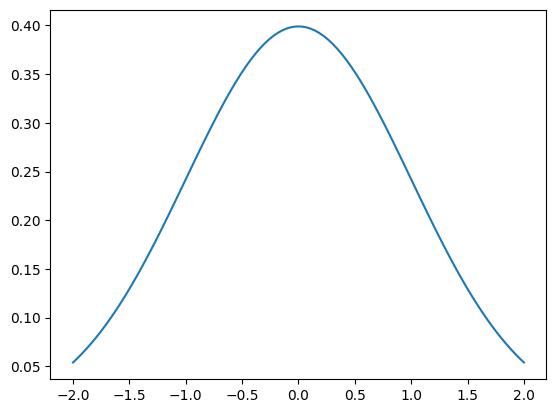

In [19]:
import matplotlib.pyplot as plt


x = np.linspace(-2, 2, 100)
y = [gaussian(x, 0, 1) for x in np.linspace(-2, 2, 100)]
plt.plot(x, y)


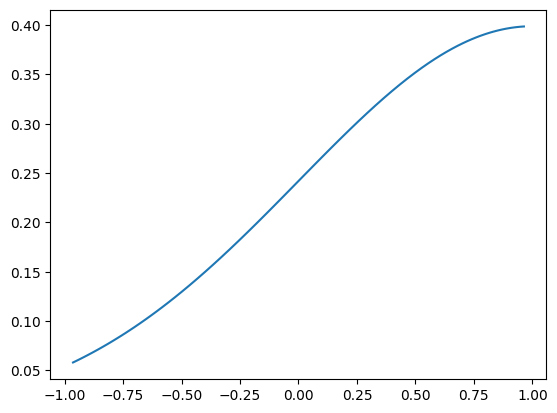

In [22]:
x = np.tanh(np.linspace(-2, 2, 100))
y = [gaussian(x, 1, 1) for x in np.tanh(np.linspace(-2, 2, 100))]
plt.plot(x, y)


In [12]:
import torch

torch.arctanh(torch.tensor(1 - 1e-6))


tensor(7.2477)

In [1]:
import pickle

with open("pen-human_data.pkl", "rb") as fp:
    data = pickle.load(fp)


In [10]:
import numpy as np

np.where(data["timeouts"] == 1)[0]


array([ 199,  399,  599,  799,  999, 1199, 1399, 1599, 1799, 1999, 2199,
       2399, 2599, 2799, 2999, 3199, 3399, 3599, 3799, 3999, 4199, 4399,
       4599, 4799, 4999])

In [18]:
np.set_printoptions(suppress=True)
print(data["rewards"][300:400])


[60.914936 60.914932 60.914936 60.914936 60.914932 60.914936 60.91493
 60.914936 60.914932 60.914936 60.914932 60.914936 60.914932 60.914936
 60.914932 60.914932 60.914932 60.914932 60.914936 60.914932 60.914936
 60.914932 60.914936 60.914932 60.914936 60.914932 60.914936 60.914932
 60.914932 60.914932 60.914936 60.914936 60.914932 60.914936 60.914932
 60.914936 60.914932 60.914936 60.914932 60.914936 60.914932 60.914936
 60.914936 60.914936 60.914936 60.914932 60.914936 60.914932 60.914936
 60.914932 60.914936 60.914932 60.914936 60.914932 60.914936 60.914936
 60.914936 60.914936 60.914932 60.914936 60.914936 60.914936 60.914932
 60.914936 60.914932 60.914936 60.914936 60.914936 60.914936 60.914936
 60.914936 60.914936 60.914936 60.914936 60.914936 60.914932 60.914936
 60.914932 60.91494  60.914936 60.91494  60.914936 60.91494  60.914936
 60.914936 60.914936 60.91494  60.91494  60.914936 60.91494  60.914936
 60.91494  60.914936 60.91494  60.914936 60.91494  60.914936 60.91494
 60.9149

In [25]:
import pickle

with open("walker2d_data.pkl", "rb") as fp:
    data = pickle.load(fp)


In [27]:
import numpy as np

len(np.where(data["terminals"] == 1)[0])


513

In [28]:
len(np.where(data["timeouts"] == 1)[0])


677

In [1]:
import gym

In [10]:
gym.make('Hopper-v2')

Import error. Trying to rebuild mujoco_py.


DependencyNotInstalled: libglewegl.so: cannot open shared object file: No such file or directory. (HINT: you need to install mujoco_py, and also perform the setup instructions here: https://github.com/openai/mujoco-py/.)

In [9]:
%set_env LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/afs/inf.ed.ac.uk/user/s21/s2139934/.mujoco/mujoco210/bin:/usr/lib/nvidia

env: LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/afs/inf.ed.ac.uk/user/s21/s2139934/.mujoco/mujoco210/bin:/usr/lib/nvidia
